# Deep Convolutional GAN

## Library imports

In [10]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid 
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

## Generator

In [11]:
class Generator(nn.Module):
    '''
    Generator Class
    
    Parameters:
        z_dim: Dimension of the noise vector, a scalar
        im_channels: Number of channels in the generated image (default: 1), a scalar
        hidden_dim: The inner dimension, a scalar
    '''
    
    def __init__(self, z_dim=10, im_channels=1, hidden_dim=64):
        '''
        Create a Generator
        '''
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim*4),
            self.make_gen_block(hidden_dim*4, hidden_dim*2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim*2, hidden_dim, kernel_size=3, stride=2),
            self.make_gen_block(hidden_dim, im_channels, kernel_size=2, stride=2, final_layer=True)
        )
    
    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Create a sequence of operations corresponding to a Generator block of DCGAN.
        Sequence of a transposed convolution, a batchnorm (except for in the last layer), and an activation.
        
        Parameters:
            input_channels: Number of channels in the input feature representation.
            output_channels: Number of channels in the output feature representation.
            kernel_size: The size of each convolutional filter (default=3).
            stride: The stride of the convolution (default=2).
            final_layer: Keep Track of the final layer, a boolean (default=False).
        '''
        if final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh()
            )
        
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
            )
        
    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.gen(noise)

## Noise

In [12]:
def generate_noise(n_samples=100, z_dim=10, device="cpu"):
    '''
    Generate a noise tensor of shape (n_samples, z_dim, 1, 1)
    
    Parameters:
        n_sample: Number of samples in noise tensor, a scalar.
        z_dim: Dimension of noise vector, a scalar.
    '''
    noise = torch.randn(n_samples, z_dim).to(device)
    return noise.view(len(noise), z_dim, 1, 1) #width=1, height=1, n_channels=n_dim

## Discriminator

In [13]:
class Discriminator(nn.Module):
    '''
    Discriminator class
    
    Parameters:
        im_channels: Number of channels in the input image, a scalar
        hidden_dim: The inner dimension, a scalar
    '''
    def __init__(self, im_channels=1, hidden_dim=16):
        '''
        Create a Discriminator
        '''
        super(Discriminator, self).__init__()
        
        self.disc = nn.Sequential(
            self.make_disc_block(im_channels, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim*2),
            self.make_disc_block(hidden_dim*2, 1, final_layer=True)
        )
    
    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Create a sequence of operations corresponding to a Discriminator block of DCGAN.
        Sequence of a convolution, a batchnorm (except for in the last layer), and an activation.
        
        Parameters:
            input_channels: Number of channels in the input feature representation.
            output_channels: Number of channels in the output feature representation.
            kernel_size: The size of each convolutional filter (default=3).
            stride: The stride of the convolution (default=2).
            final_layer: Keep Track of the final layer, a boolean (default=False).
        '''
        if final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(negative_slope=0.2, inplace=True)
            )
    
    def forward(self, image):
        return self.disc(image).view(len(image), -1)

## Training

  *   criterion: the loss function
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   beta_1, beta_2: the momentum term
  *   device: the device type

In [14]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [15]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 100
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
beta_1, beta_2 = 0.5, 0.999
device = "cuda"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataloader = DataLoader(
    MNIST('.', download=False, transform=transform),
    batch_size=batch_size,
    shuffle=False
)

In [16]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# You initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
        
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

  7%|▋         | 31/469 [00:04<00:56,  7.69it/s]

Epoch 1, step 500: Generator loss: 1.0520854353904725, discriminator loss: 0.44019099941849704


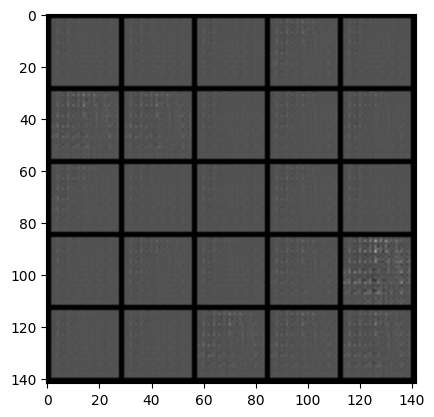

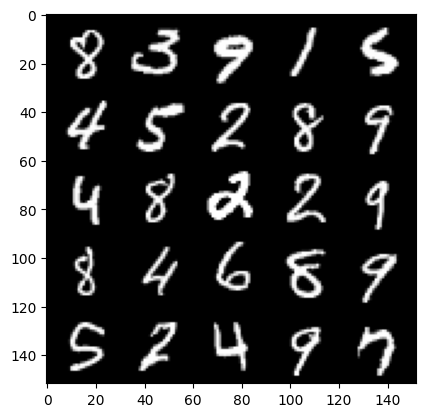

 13%|█▎        | 62/469 [00:08<00:55,  7.35it/s]

Epoch 2, step 1000: Generator loss: 2.672734305858611, discriminator loss: 0.08466818127781156


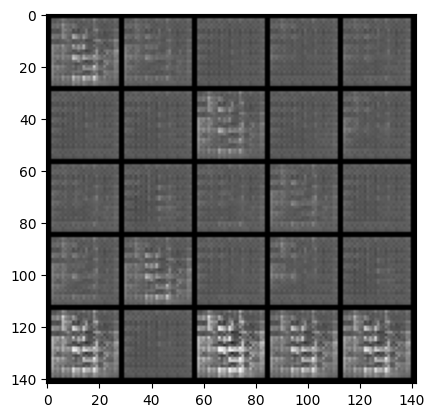

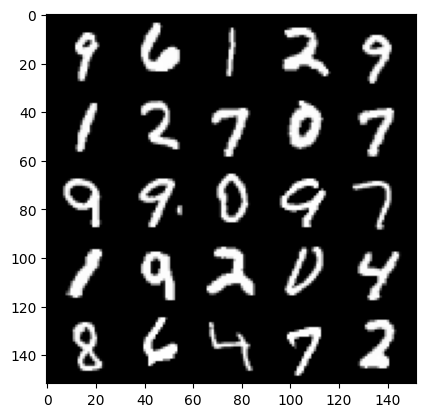

 20%|█▉        | 93/469 [00:12<00:50,  7.44it/s]

Epoch 3, step 1500: Generator loss: 2.1415603124201295, discriminator loss: 0.3127603131011129


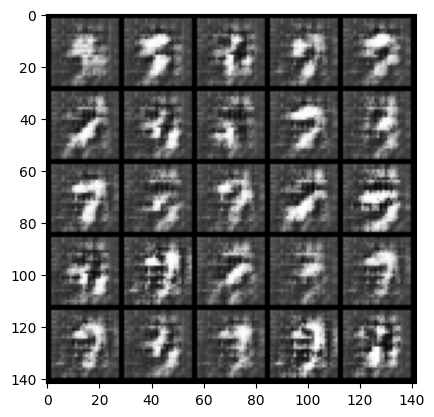

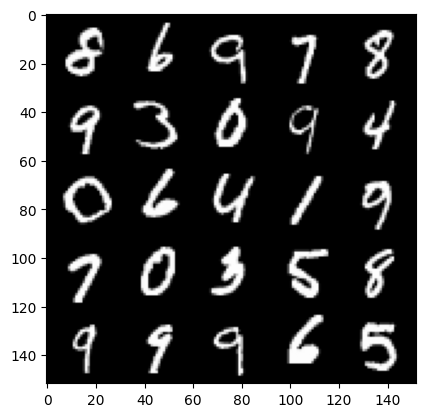

 26%|██▋       | 124/469 [00:20<00:50,  6.89it/s]

Epoch 4, step 2000: Generator loss: 1.402527342364191, discriminator loss: 0.43447702041268343


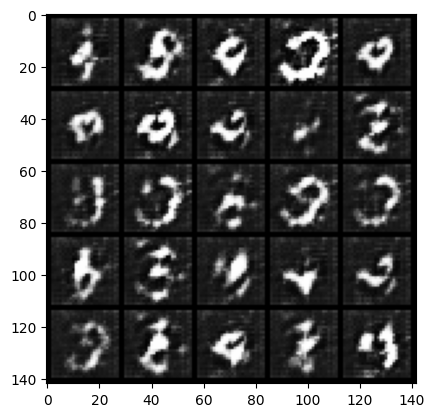

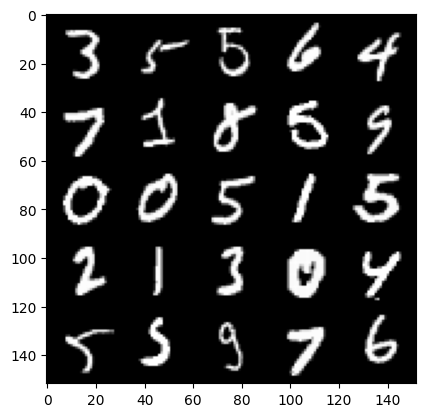

 33%|███▎      | 155/469 [00:21<00:41,  7.48it/s]

Epoch 5, step 2500: Generator loss: 1.1460445164144042, discriminator loss: 0.4861450171470643


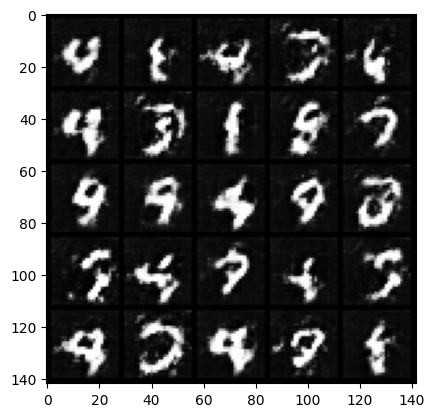

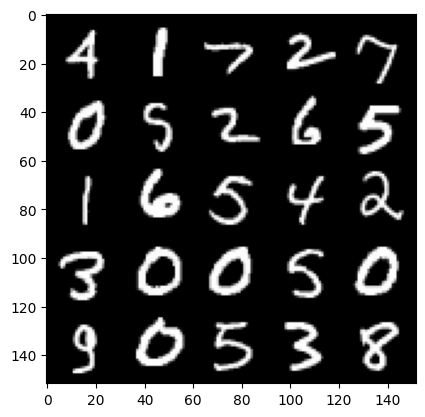

 40%|███▉      | 186/469 [00:26<00:36,  7.66it/s]

Epoch 6, step 3000: Generator loss: 1.0108585650324817, discriminator loss: 0.5235945612788202


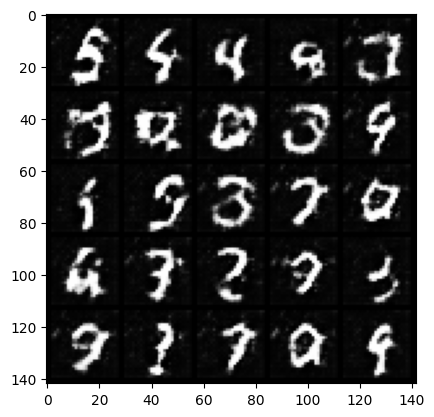

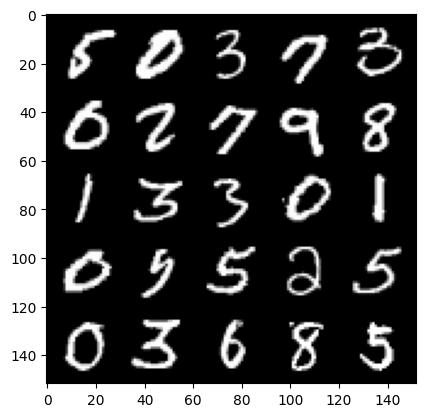

 46%|████▋     | 217/469 [00:34<00:33,  7.48it/s]

Epoch 7, step 3500: Generator loss: 0.9544802261590971, discriminator loss: 0.5318739970326418


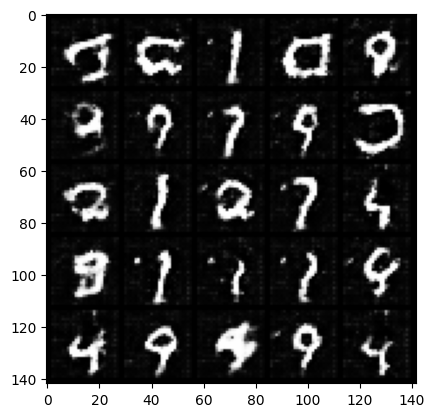

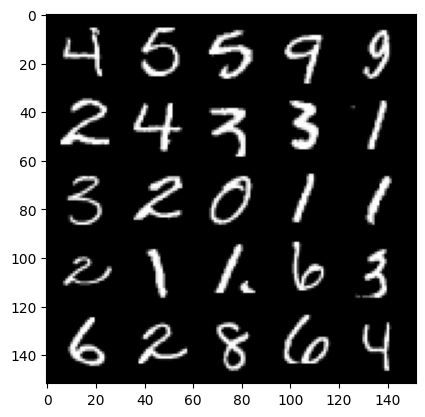

 53%|█████▎    | 248/469 [00:33<00:29,  7.54it/s]

Epoch 8, step 4000: Generator loss: 0.9599326481819153, discriminator loss: 0.5228054519295692


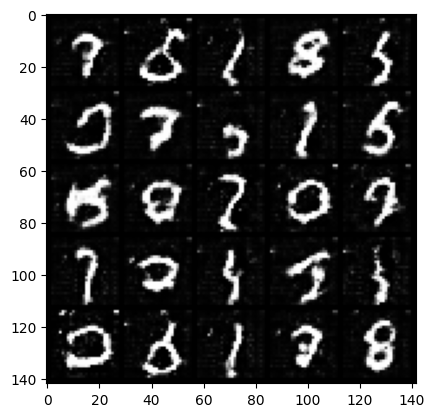

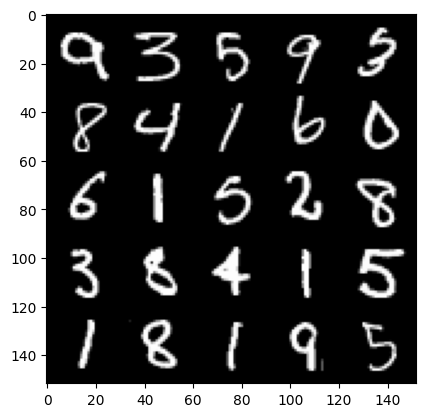

 59%|█████▉    | 279/469 [00:38<00:26,  7.18it/s]

Epoch 9, step 4500: Generator loss: 0.9830486931800836, discriminator loss: 0.5084260064959529


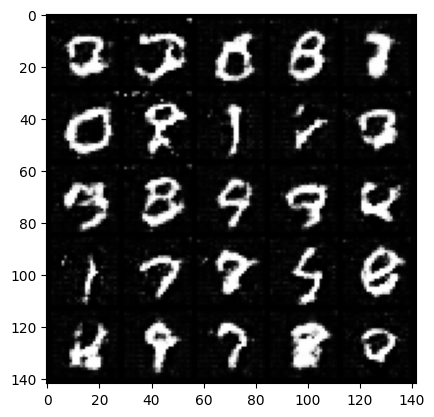

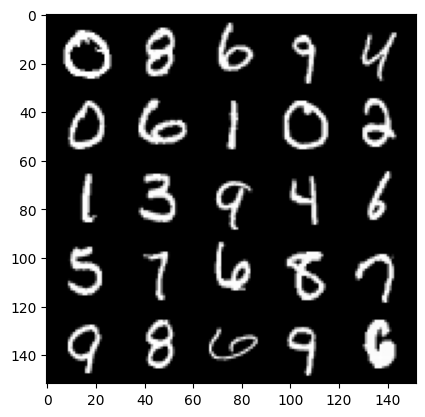

 66%|██████▌   | 310/469 [00:46<00:21,  7.36it/s]

Epoch 10, step 5000: Generator loss: 1.0125816570520407, discriminator loss: 0.49176318007707553


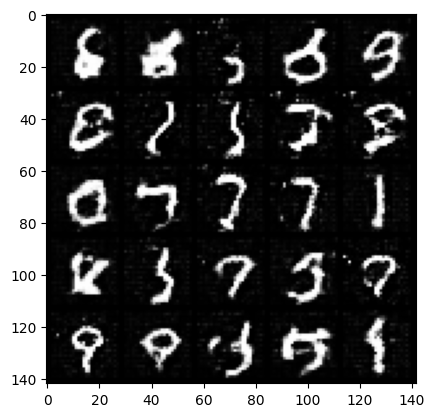

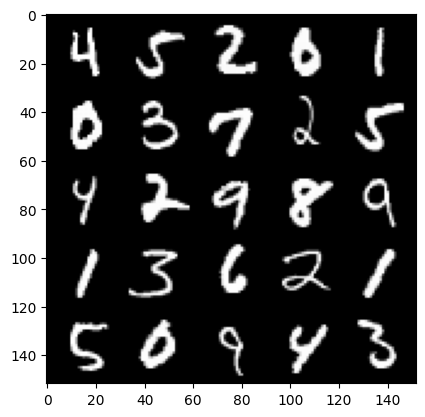

 73%|███████▎  | 341/469 [00:48<00:16,  7.63it/s]

Epoch 11, step 5500: Generator loss: 1.0456958550810809, discriminator loss: 0.47396751004457516


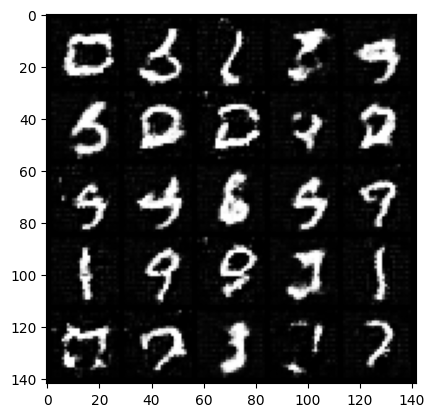

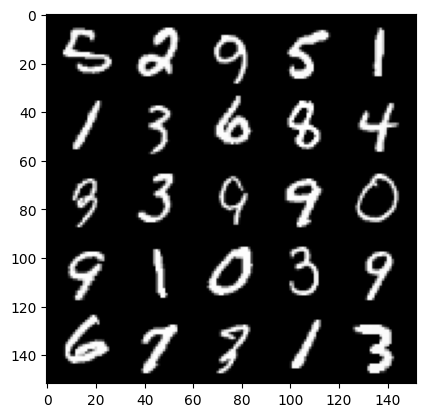

 79%|███████▉  | 372/469 [00:50<00:13,  7.31it/s]

Epoch 12, step 6000: Generator loss: 1.0814078956842417, discriminator loss: 0.45585816335678075


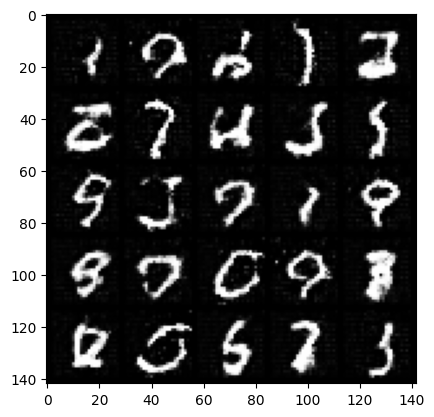

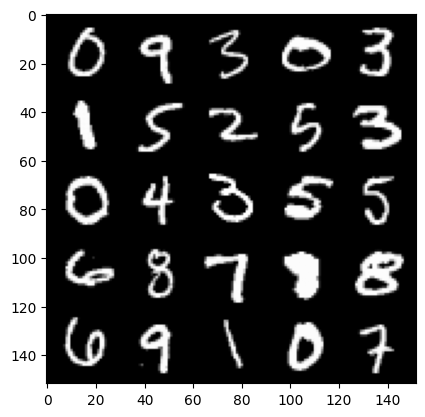

 82%|████████▏ | 383/469 [00:53<00:11,  7.19it/s]


KeyboardInterrupt: 

In [17]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update discriminator ##
        disc_opt.zero_grad()
        fake_noise = generate_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = generate_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
